# Spis tre≈õci

1. [Problematyka](#problematyka)
2. [Charakterystyka danych]()
    1. [Rozk≈Çad liczebno≈õci tweet√≥w i tag√≥w w tek≈õcie](#rozklad_1)
    2. [Rozk≈Çad s≈Ç√≥w w tek≈õcie](#rozklad_2)
    3. [Rozk≈Çady emotikonek w tek≈õcie](#rozklad_3)
    4. [Rozk≈Çad najczƒô≈õciej wystƒôpujƒÖcych s≈Ç√≥w w tek≈õcie](#rozklad_4)
    5. [Wnioski z analizy danych](#wnioski_1)
3. [Uczenie algorytm√≥w](#uczenie_algorytmow)
    1. [Przygotowanie danych](#przygotowanie_danych)
    2. [Uczenie i ocena modeli](#uczenie_ocena_modeli)
        1. [Baseline](#baseline)
        2. [Naive Bayes](#naive_bayes)
        3. [Support Vector Machines](#svm)
        4. [PolBERT](#polbert)
    3. [Por√≥wnanie wynik√≥w](#porownanie_wynikow)
    4. [Podsumowanie budowy modeli](#podsumowanie_budowy_modeli)
4. [Potencjalne dalsze kroki](#dalsze_kroki)
5. [Kolejny skrypt](#kolejny_skrypt)
        


---
---
<a id="problematyka"></a>
# Problematyka

Konkurs PolEval jest konkursem dla szeroko pojƒôtej spo≈Çeczno≈õci data scientist, w kt√≥rym zadania dotyczƒÖ aspekt√≥w zwiƒÖzanych z przetwarzaniem jƒôzyka naturalnego. Celem konkursu jest zar√≥wno dog≈Çƒôbniejsze zrozumienie problem√≥w w przetwarzaniu jƒôzyka naturalnego jak i opracowanie nowych metod dla jƒôzyka polskiego, kt√≥re mogƒÖ je rozwiƒÖzaƒá. Jednym z takich zada≈Ñ jest wykrywanie mowy nienawi≈õci ([zadanie 6.2](http://2019.poleval.pl/index.php/tasks/task6)). BiorƒÖc pod uwagƒô rozw√≥j technologiczny obserwowany na codzie≈Ñ oraz fakt, ≈ºe media spo≈Çeczno≈õciowe stajƒÖ siƒô coraz wa≈ºniejszym elementem naszego ≈ºycia, problem podjƒôty w tym zadaniu jest niezwykle istotny, bowiem na codzie≈Ñ ka≈ºdy z u≈ºytkownik√≥w internetu spotyka siƒô w mniejszym lub wiƒôkszym stopniu z mowƒÖ nienawi≈õci, kt√≥ra w zale≈ºno≈õci od odporno≈õci psychicznej cz≈Çowieka mo≈ºe doprowadziƒá do r√≥≈ºnych problem√≥w natury psychicznej. 

W przypadku zadania z PolEval2019, mamy do czynienia z tre≈õciami tweet√≥w w jƒôzyku polskim, kt√≥re zosta≈Çy zaklasyfikowane w 3 kategorie:

1. `non-harmful` - tweety o tre≈õci nieszkodliwej;
2. `cyberbulling` - tweety charakteryzujƒÖce siƒô mowƒÖ nienawi≈õci, kt√≥re zosta≈Çy skierowane wobec os√≥b prywatnych;
3. `hate-speech` - tweety charakteryzujƒÖce siƒô mowƒÖ nienawi≈õci, kt√≥re zosta≈Çy skierowane wobec os√≥b publicznych, instytucji czy grup spo≈Çecznych.

Celem jest zbudowanie mo≈ºliwe jak najlepszego rozwiƒÖzania kategoryzujƒÖcego tweety - w tym celu dysponujemy dwoma zbiorami: uczƒÖcym oraz testowym.

<a id="charakterystyka_danych"></a>
# Charakterystyka danych

W pierwszym etapie skupiƒô sie na analizie zbior√≥w tweet√≥w, w ramach kt√≥rej chce poznaƒá strukture zbioru:

1. Jego liczno≈õƒá, 
2. Reprezentatywno≈õƒá poszczeg√≥lnych kategorii,
3. "W≈Ça≈õciwo≈õci" tekst√≥w, na kt√≥rych bƒôdziemy pracowaƒá.

Sformu≈Çowane wnioski na podstawie tej analizy stanowiƒá bƒôdƒÖ podstawƒô do kolejnych krok√≥w, w kt√≥rych przygotowany zostanie odpowiedni proces przekszta≈Çcenia danych oraz zaproponowane zostanƒÖ pierwsze algorytmy kategoryzujƒÖce tweety.

In [3]:
import os
import re
from collections import Counter
import random

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.validation import check_is_fitted
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from preprocessing import (
    read_texts_and_tags,
    merge_texts,
    tokenize_texts,
    search_non_ascii,
    search_text_with_word,
    WordCaser,
    PolishLetterReplacer,
    PunctuationRemover,
    StopWordsRemover,
    NonAsciiCharactersRemover,
    CurrencyRemover,
    UnitsRemover,
    NumberReplacer,
    WhitespaceRemover,
    NonAsciiCharacterWhitespaceSurrounder,
    PolBERTFeatureConstructor
)

from visualization import (
    plot_tags_distribution,
    plot_text_distribution,
    plot_non_ascii_distribution,
    calc_top_words_distribution
)

from validation import (
    show_top_n_words_naive_bayes,
    show_classification_report,
    check_inference_time
)

from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
    align-items: center;
}
</style>
""")

SEED = 2021

In [4]:
path_data_folder = os.path.join(os.getcwd(), 'data')

texts_train, tags_train = read_texts_and_tags(path_data_folder, 'train')
texts_test, tags_test = read_texts_and_tags(path_data_folder, 'test')

<a id="rozklad_1"></a>
## Rozk≈Çad liczebno≈õci tweet√≥w i tag√≥w w tek≈õcie

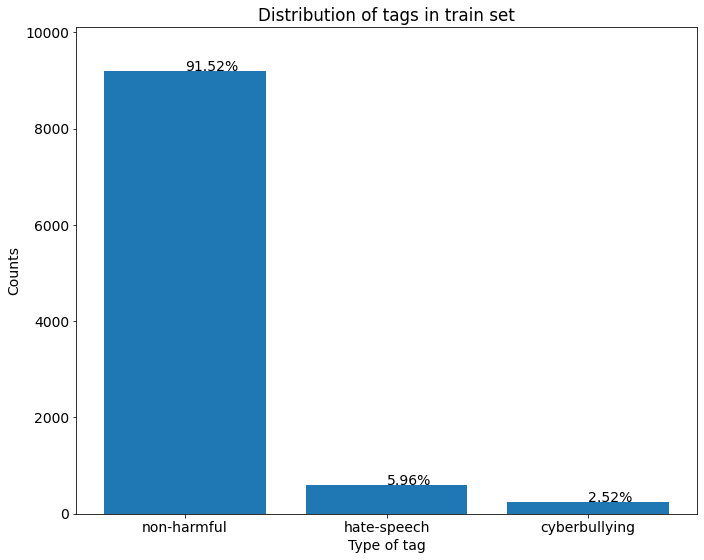

In [3]:
plot_tags_distribution(tags_train, title='Distribution of tags in train set')

In [4]:
print(f'Train set counts: {texts_train.shape[0]}')
print(f'Test set counts: {texts_test.shape[0]}')

Train set counts: 10041
Test set counts: 1000


Dysponujemy dwoma zbiorami:

1. Zbiorem uczƒÖcym, d≈Çu≈ºƒÖcym do nauki algorytm√≥w, liczƒÖcym 10041 tweet√≥w oraz
2. Zbiorem testowym, na kt√≥rym dokonana zostanie ostateczna ewaluacja algorytm√≥w, liczƒÖcym 1000 tweet√≥w.

BiorƒÖc pod uwagƒô [≈õredniƒÖ liczbƒô tweet√≥w na sekundƒô wynoszƒÖcƒÖ 6000 w 2020 roku](https://www.dsayce.com/social-media/tweets-day/), dysponujemy niewielkim u≈Çamkiem tweet√≥w jakie mo≈ºemy znale≈∫ƒá w sieci. 

Dodatkowo analizujƒÖc rozk≈Çady kategorii w zbiorze uczƒÖcym dostrzegamy, ≈ºe mamy problem z niedoreprezentatywno≈õciƒÖ kategorii identyfikujƒÖcych mowe nienawi≈õci - jest to tylko oko≈Ço 6% zbioru dla kategorii *hate-speech* oraz oko≈Ço 2,5% zbioru dla kategorii *cyberbullying*. 

Ze wzglƒôdu na tak du≈ºƒÖ niedoreprezentatywno≈õƒái, najprawdopodobniej bƒôdziemy mieli du≈ºe problemy z nauczeniem algorytm√≥w w identyfikacji tych dw√≥ch kluczowych, z punktu widzenia podjƒôtej problematyki, kategorii.  

*Powy≈ºszy wykres oraz dalsze analizy skupiaƒá siƒô bƒôdƒÖ na analizie tylko i wy≈ÇƒÖcznie zbioru uczƒÖcego. Nie "zaglƒÖdamy" do zbioru testowego, aby nie dopu≈õciƒá do utworzenia czego≈õ w rodzaju "mentalnego obciƒÖ≈ºenia" polegajƒÖcego na podejmowaniu decyzji, kt√≥re pod≈õwiadomie kierowaƒá bƒôdƒÖ Nas w celu "dopasowania siƒô do zbioru testowego".*

<a id="rozklad_2"></a>
## Rozk≈Çad s≈Ç√≥w w tek≈õcie

W kolejnym etapie, przyjrzyjmy siƒô rozk≈Çadowi s≈Ç√≥w wystƒôpujƒÖcych w tek≈õcie jeszcze przed jego obr√≥bkƒÖ.

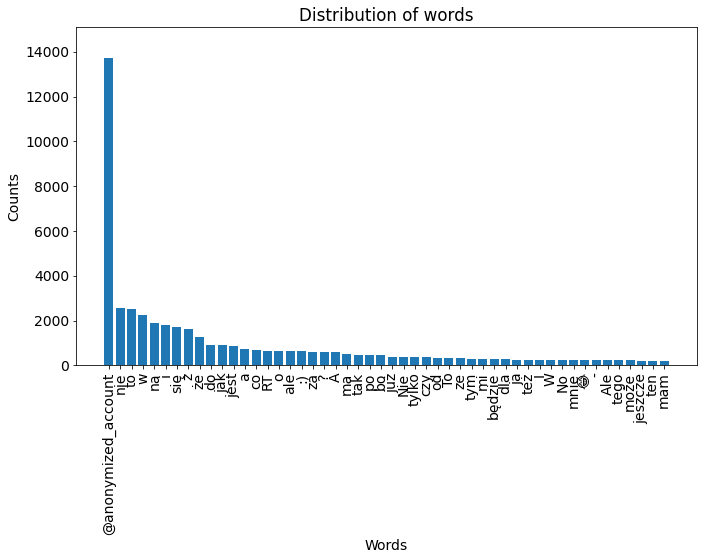

In [5]:
n_top_words = 50
plot_text_distribution(texts_train, n_top_words)

Tekst nie jest jeszcze w ≈ºaden spos√≥b obrobiony - na ten moment wykres przedstawia rozk≈Çad s≈Ç√≥w w "surowym" tek≈õcie.

Wnioski p≈ÇynƒÖce z powy≈ºszego wykresu:

1. Tak jak w przypadku wszystkich problem√≥w dotyczƒÖcych przetwarzania jezyka naturalnego, przy badaniu rozk≈Çadu s≈Ç√≥w w surowym tek≈õcie spodziewane jest by otrzymaƒá rozk≈Çad sk≈ÇadajƒÖcy siƒô niemal≈ºe z samym stop-words√≥w, tzn. wyraz√≥w i wyra≈ºe≈Ñ, kt√≥re uzupe≈ÇniajƒÖ tekst oraz nadajƒÖ mu znaczenia, ale samodzielnie nie przekazujƒÖ g≈Çƒôbszej my≈õli, sensu lub konkretnych informacji np. a, co, ma, po, te≈º itd. - oznacza to, ≈ºe niezbƒôdnym w procesie przygotowania danych bƒôdzie ich usuniƒôcie.
2. Na pierwszym miejscu wystƒôpujƒô s≈Çowo "@anonymized_account", kt√≥re zgodnie z opisem zadania oznacza wynik procesu anonimizacji - wszelkie wskazania wprost, kt√≥re jednoznacznie mogƒÖ zidentyfikowaƒá osobƒô publikujƒÖcƒÖ tweety sƒÖ anonimizowane. Zatem te s≈Çowo wystƒôpujƒÖce w danych mo≈ºe zostaƒá usuniƒôte bez obaw o utratƒô cennych informacji - wrƒôcz przeciwnie, s≈Çowo "@anonymized_account" wprowadza tylko szum.
3. W≈õr√≥d dalszych s≈Ç√≥w wystƒôpuje r√≥wnie≈º "RT", kt√≥re nie jest s≈Çowem polskim, a skr√≥ceniem wyra≈ºe≈Ñ "Replying to", kt√≥re powstaje w sytuacji odpowiedzi na kt√≥rego≈õ z tweet√≥w. S≈Çowo "RT", podobnie jak s≈Çowo "@anonymized_account" wprowdza szum i powinno zostaƒá usuniƒôte.
4. W≈õr√≥d s≈Ç√≥w dostrzegamy r√≥wnie≈º emotikonki w dw√≥ch postaciach - tekstowych np. ":)" oraz graficznych np. "üòÄ". Punkt ten dok≈Çadniej om√≥wimy w kolejnych etapach.

<a id="rozklad_3"></a>
## Rozk≈Çady emotikonek w tek≈õcie

Emotikonki zawarte w tek≈õcie mogƒÖ dostarczyƒá nam precyzyjniejszej informacji o charakterze tweeta, bowiem sƒÖ one czƒôsto reprezentantem naszych emocji jakie towarzyszƒÖ Nam podczas tweetowania. Jednak≈ºe sƒÖ one zarazem wieloznaczne - u≈õmiech mo≈ºe reprezentowaƒá rado≈õƒá lub te≈º wy≈õmiewanie siƒô, szydzenie. 

Przyjrzyjmy siƒô dok≈Çadniej rozk≈Çadom emotikonek w tek≈õcie.

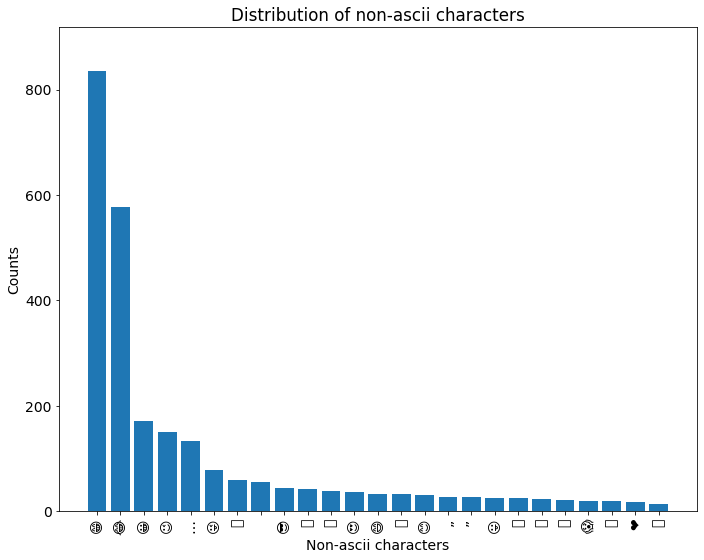

In [6]:
plot_non_ascii_distribution(
    texts_train,
    n_top_words=25,
    xlabel='Non-ascii characters',
    title='Distribution of non-ascii characters'
)

In [7]:
texts_non_ascii = search_non_ascii(texts_train)
texts_non_ascii = texts_non_ascii[texts_non_ascii != '']
n_non_ascii = texts_non_ascii.shape[0]
dist_non_ascii = n_non_ascii/texts_train.shape[0]
print(f'Number of tweets with atleast one emote {n_non_ascii} = {dist_non_ascii*100:.2f}%')

Number of tweets with atleast one emote 1562 = 15.56%


DominujƒÖcƒÖ emotikonkƒÖ w tek≈õcie jest emotikonka reprezentujƒÖca u≈õmiech z zamkniƒôtymi oczami üòÅ, nastƒôpnie mamy u≈õmiech z ≈Çzami w oczach üòÇ, zwyk≈Çy u≈õmieszek üòÄ, puszczenie oczka üòâ, czy wystawienie jƒôzyka üòú.

*Niestety czƒô≈õƒá z nich nie jest mo≈ºliwa do wyrenderowania przez pakiet matplotlib, dlatego obserwujemy kwadraciki*

Co to dla Nas oznacza? Mamy doczynienia raczej z "weso≈Çymi" emotikonkami. "Weso≈Çymi" na pierwszy rzut oka, bowiem to wszystko zale≈ºy od tego jaki mamy dob√≥r s≈Ç√≥w, kt√≥ry szerzej m√≥g≈Çby Nam powiedzieƒá, czy emotikonka przedstawia faktycznie rado≈õƒá, czy mo≈ºe szydzenie, kt√≥re wchodziƒá mo≈ºe w mowe nienawi≈õci.

Liczebno≈õci emotikonek wskazujƒÖ, ≈ºe nie sƒÖ one rzadkie - 15,56% tweet√≥w posiada conajmniej jednƒÖ emotikonkƒô.

Sprawd≈∫my zatem jak wyglƒÖda to w poszczeg√≥lnych kategoriach.

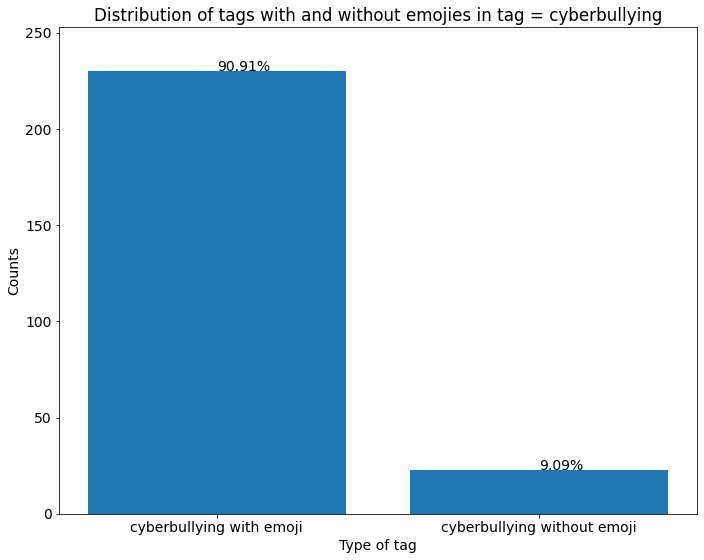

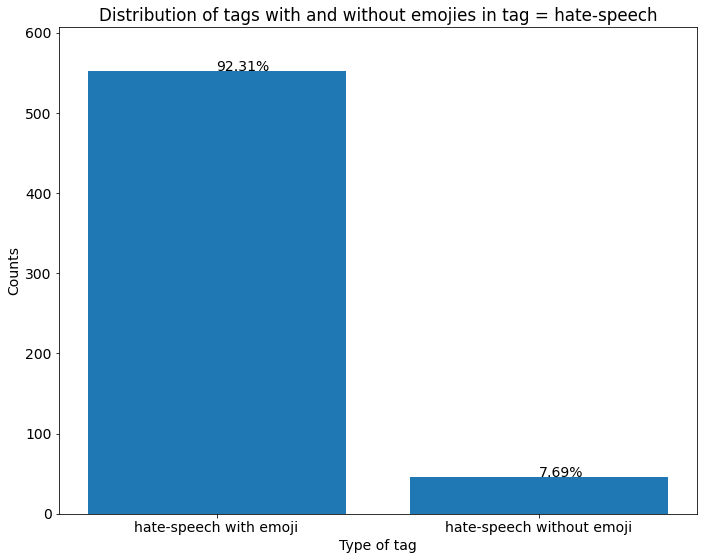

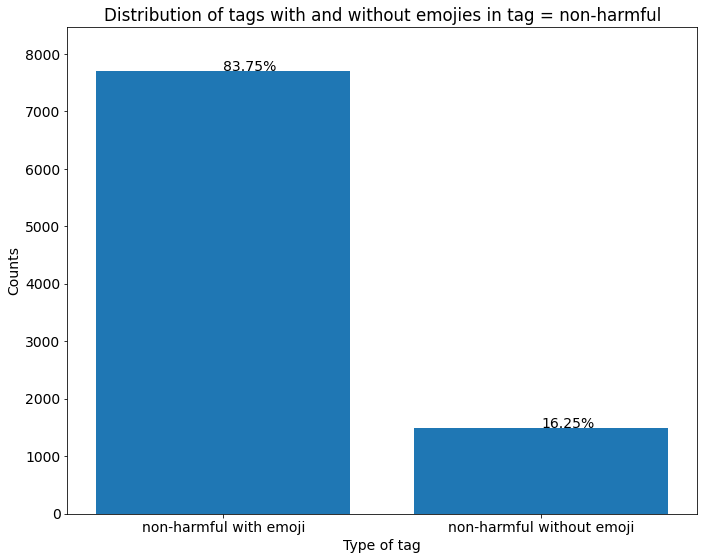

In [8]:
for tag in np.unique(tags_train):
    idx_tags = tags_train == tag

    texts = texts_train[idx_tags]
    texts = search_non_ascii(texts)

    tags = tags_train[idx_tags]
    tags = [f'{tag} without emoji' if text != '' else f'{tag} with emoji'
            for text, tag in zip(texts, tags)]
    title = f'Distribution of tags with and without emojies in tag = {tag}'
    plot_tags_distribution(tags, title=title)

Kategoria *non-harmful* charakteryzuje siƒô tweetami o najwiƒôkszym udziale tweet√≥w z conajmniej jednƒÖ emotikonkƒÖ, tj. 16,25%. W przypadku kategorii z mowƒÖ nienawi≈õci udzia≈Ç tych tweet√≥w jest znacznie mniejszy i wynosi odpowiednio 7,69% dla kategorii *hate-speech* oraz 9,09% dla kategorii *cyberbulling*.

BiorƒÖc pod uwagƒô najczƒô≈õciej wystƒôpujƒÖce emotikonki oraz rozk≈Çad tweet√≥w z conajmniej jednƒÖ emotikonkƒÖ spodziewaƒá siƒô mo≈ºna, ≈ºe "weso≈Çe" emotikonki mogƒÖ wystƒôpowaƒá we wszystkich kategoriach, co spowoduje ich wieloznaczno≈õƒá, kt√≥re istotnie mo≈ºe utrudniƒá identyfikacjƒô kategorii przez algorytmy. Przyjrzyjmy siƒô zatem rozk≈Çadom emotikonek w poszczeg√≥lnych kategoriach.

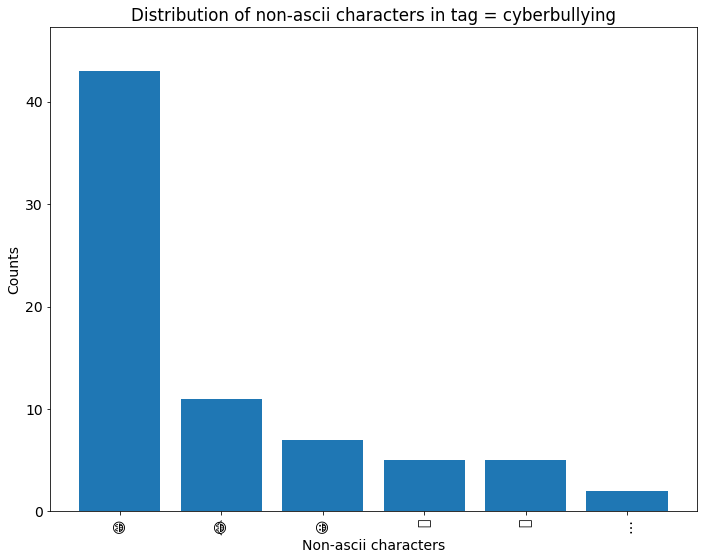

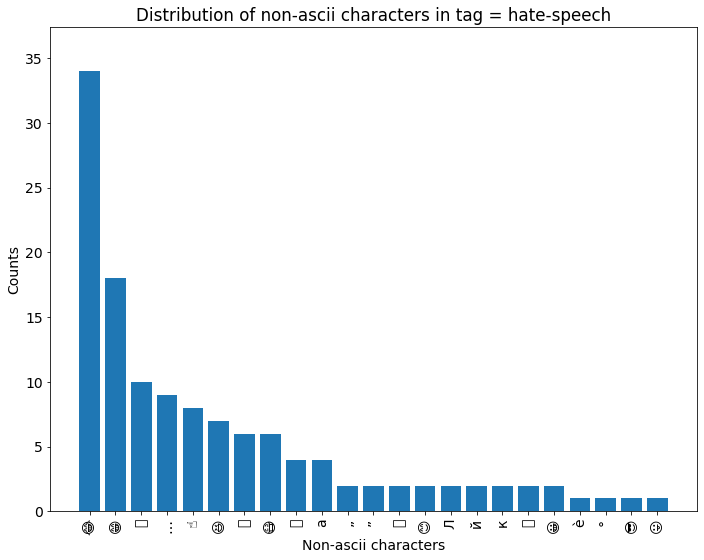

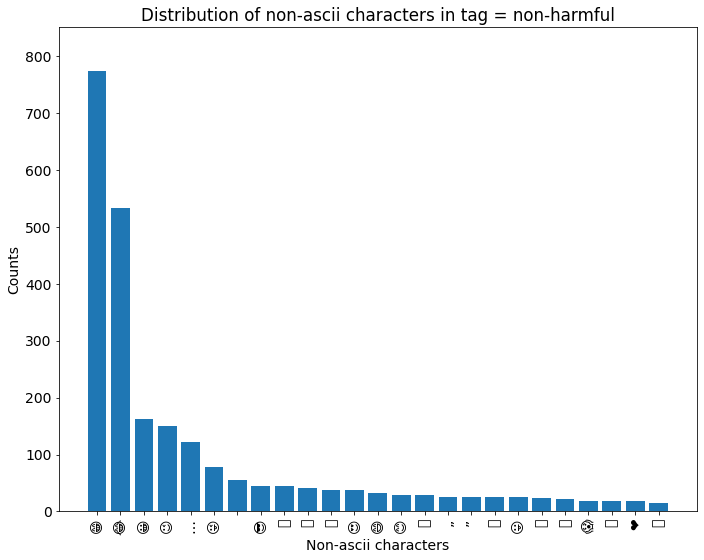

In [9]:
for tag in np.unique(tags_train):
    idx_tags = tags_train == tag
    plot_non_ascii_distribution(
        texts_train[idx_tags],
        n_top_words=25,
        xlabel='Non-ascii characters',
        title=f'Distribution of non-ascii characters in tag = {tag}'
    )

AnalizujƒÖc powy≈ºsze wykresy rozk≈Çad√≥w emotikonek w poszczeg√≥lnych kategoriach dostrzec mo≈ºna, ≈ºe "weso≈Çe" emotki sƒÖ najczƒô≈õciej wystƒôpujƒÖcymi emotkami w ka≈ºdej z kategorii - potwierdza to obawy, jakie zosta≈Çy wcze≈õniej skonstruowane, tzn. bƒôdƒÖ one wieloznaczne. Innymi s≈Çowy, obecno≈õƒá "weso≈Çych" emotek niekoniecznie mo≈ºe u≈Çatwiƒá kategoryzacjƒô tweet√≥w.

Powy≈ºsze wnioski zosta≈Çy zaprezentowane ni≈ºej w innej, zbiorczej formie, kt√≥ra por√≥wnuje najczƒô≈õciej wystƒôpujƒÖce emotki ze sobƒÖ.

In [10]:
texts_non_ascii = search_non_ascii(texts_train)
top_non_ascii_distribution = calc_top_words_distribution(
    texts_non_ascii,
    tags_train,
    split_point=''
)
top_non_ascii_distribution.style

Powy≈ºsza tabela przedstawia:

1. W wierszach suma zbior√≥w emotek, kt√≥re sƒÖ najczƒô≈õciej wystƒôpujƒÖce w ka≈ºdej z kategorii.
2. 3 kolumny - *cyberbulling*, *hate-speech* oraz *non-harmful* - kt√≥re okre≈õlajƒÖ pozycjƒô emotki w zbiorze, na podstawie czƒôsto≈õci jej wystƒôpowania.
3. Kolumna *rank* okre≈õlajƒÖca ≈õredniƒÖ z ranking√≥w, kt√≥ra s≈Çu≈ºy do sortowania wynik√≥w tabel - od najczƒôstszych emotek do najrzadszych.

Wnioski z tabeli:

1. "Weso≈Çe" emotki najczƒô≈õciej wystƒôpujƒÖce tzn. üòÇ, üòÅ, üòÄ sƒÖ zarazem emotkami najczƒô≈õciej wystƒôpujƒÖcymi we wszystkich trzech kategoriach - oznacza to, ≈ºe sƒÖ wieloznaczne i ich obecno≈õƒá w tweetach najprawdopodobniej nie wp≈Çynie istotnie na kategoryzacjƒô.
2. Istnieje emotka "‚Ä¶", kt√≥rƒÖ nie jeste≈õmy w stanie zinterpretowaƒá.
3. Rozk≈Çad emotki ü§£, wskazuje, ≈ºe czƒô≈õciej jest ona u≈ºywana w ramach mowy nienawi≈õci (zapewne do szydzenia) ni≈º w tweetach normalnych.
4. IstniejƒÖ emotki, kt√≥re sƒÖ specyficzne dla danej kategorii i nie wystƒôpujƒÖ w ≈ºadnych innych kategoriach lub ich wystƒôpowalno≈õƒá jest bardzo znikoma (*pamiƒôtajmy, ≈ºe powy≈ºsza tabelka zawiera 10 najczƒô≈õciej wystƒôpujƒÖcych emotikonek w tek≈õcie*) np.:
    1. üëç dla *cyberbulling*
    2. ‚òù (≈õrodkowy palec), ‚ùó dla *hate-speech*
    3. üí™, üòâ dla *non-harmful*

<a id="rozklad_4"></a>
## Rozk≈Çad najczƒô≈õciej wystƒôpujƒÖcych s≈Ç√≥w w tek≈õcie

Wykonajmy podobnƒÖ analizƒô jak wy≈ºej dla najczƒô≈õciej wystƒôpujƒÖcych s≈Ç√≥w w tek≈õcie. 

Jednak≈ºe zanim go stworzymy, wcze≈õniej dokonane obserwacje pos≈Çu≈ºƒÖ Nam do stworzenia pierwszego, potencjalnego pipeline do wyczyszczenia tekstu:

1. `WhitespaceRemover()` - Na wstƒôpnie usuniemy bia≈Çe znaki z poczƒÖtku oraz ko≈Ñca tweeta oraz zamienimy wielokrotne spacje pomiƒôdzy poszczeg√≥lnymi s≈Çowami na pojedynczƒÖ spacjƒô - ten zabieg jest istotny z racji tego, ≈ºe proces tokenizacji najczƒô≈õciej bazuje na podziale s≈Ç√≥w w≈Ça≈õnie ze wzglƒôdu na spacjƒô. Obecno≈õƒá kilku spacji wygeneruje puste tokeny, kt√≥re niepotrzebnie mogƒÖ komplikowaƒá dalsze etapy przetwarzania tekstu.
2. `WordCaser()` - Zamieniamy na ma≈Çe litery.
3. `PolishLetterReplacer()` - Zamieniamy polskie litery diakrytyczne na ich odpowiedniki *nie-*diakrytyczne 
4. `StopWordsRemover()` - Usuwamy stop-words oraz dodatkowo zanonimizowane nazwy profili, tj. *anonymized_account* oraz oznaczenia systemowe odpowiedzi na tweety, tj. *RT*
5. `PunctuationRemover()` - Usuwamy interpunkcje - w tym momencie pozbywamy siƒô r√≥wnie≈º znak√≥w ":", kt√≥re sƒÖ elementem emotikonek tekstowych, np. ":D". Akceptujemy to, bowiem zale≈ºy w tym kroku analizie podlegajƒÖ tylko s≈Çowa i to z nich chcemy usunƒÖƒá niepotrzebne znaki interpunkcyjne.
6. `NonAsciiCharactersRemover()` - Usuwamy litery i oznaczenia non-ascii - w tym przypadku emotikonki.
7. `CurrencyRemover()` - Usuwamy oznaczenia walut, np. z≈Ç czy znak dolara 
8. `UnitsRemover()` - Usuwamy jednostki miar, np. km, cm
9. `NumberReplacer()` - Zastƒôpujemy lub usuwamy liczby - w tym przypadku usuwamy
10. `WhitespaceRemover()` - Na koniec ponownie czy≈õcimy tekst z bia≈Çych znak√≥w

In [11]:
additional_stop_words = ['anonymized_account', 'rt']
additional_punctuation = ['\\\\n', '\\.', '/', '%', '\\\\', '@']
pipeline_steps = [
    ('whitespace_remover_1', WhitespaceRemover()),
    ('word_caser', WordCaser(case='lower')),
    ('polish_letter_replacer', PolishLetterReplacer()),
    ('stop_words_remover', StopWordsRemover(additional_stop_words)),
    ('punctuation_remover', PunctuationRemover(additional_punctuation)),
    ('non_ascii_characters_remover', NonAsciiCharactersRemover()),
    ('currency_remover', CurrencyRemover()),
    ('units_remover', UnitsRemover()),
    ('number_replacer', NumberReplacer(action='delete')),
    ('whitespace_remover_2', WhitespaceRemover())
]
cleaning_pipeline = Pipeline(pipeline_steps)
texts_train_cleaned = cleaning_pipeline.fit_transform(texts_train)
texts_train_cleaned = np.array(texts_train_cleaned)
n_top_words = 15
top_words_distribution = calc_top_words_distribution(
    texts_train_cleaned,
    tags_train,
    n_top_words
)
top_words_distribution

cyberbullying  hate-speech  non-harmful      rank
chyba                  12.0          7.0          1.0  6.666667
pewnie                  NaN          NaN          6.0       NaN
masz                    3.0          NaN          5.0       NaN
pis                     NaN          3.0          NaN       NaN
troche                 10.0          NaN         15.0       NaN
pisdzielstwo            NaN          6.0          NaN       NaN
dupe                   11.0          NaN          NaN       NaN
mecz                    NaN          NaN         14.0       NaN
meczu                   NaN          NaN          8.0       NaN
polski                  NaN         13.0          NaN       NaN
chodzi                  NaN          NaN         11.0       NaN
wiesz                   7.0          NaN          NaN       NaN
xd                      NaN          NaN          4.0       NaN
siebie                  NaN         12.0          NaN       NaN
p                       NaN          NaN          9.0       NaN
wiem                    NaN         10.0          2.0       NaN
posel                   NaN         14.0          NaN       NaN
https                   NaN          NaN          3.0       NaN
jestescie               NaN          9.0          NaN       NaN
debil                   NaN         11.0          NaN       NaN
d                       NaN          NaN          7.0       NaN
czym                    8.0          NaN          NaN       NaN
chuj                   13.0          NaN          NaN       NaN
pisu                    NaN          8.0          NaN       NaN
lat                     NaN          NaN         10.0       NaN
wisla                   NaN          NaN         13.0       NaN
widze                   9.0          NaN          NaN       NaN
mozg                    4.0          NaN          NaN       NaN
jestes                  1.0          1.0          NaN       NaN
woronicza17             NaN          4.0          NaN       NaN
skoro                   NaN          NaN         12.0       NaN
debile                  NaN         15.0          NaN       NaN
idiota                 14.0          NaN          NaN       NaN
kurwa                   2.0          2.0          NaN       NaN
pajacu                  6.0          5.0          NaN       NaN
nikt                    5.0          NaN          NaN       NaN
swoim                  15.0          NaN          NaN       NaN

AnalizujƒÖc rozk≈Çady najczƒô≈õciej wystƒôpujƒÖcych s≈Ç√≥w w kategoriach dostrzec mo≈ºna, ≈ºe jest tylko jedno s≈Çowo, kt√≥re jest jednym z najliczniejszych s≈Ç√≥w we wszystkich 3 kategoriach (s≈Çowo: *chyba*) oraz jest kilka przypadk√≥w, kt√≥re sƒÖ wsp√≥lne dla dw√≥ch kategorii (6 spo≈õr√≥d 37 s≈Ç√≥w). Zatem zbiory s≈Ç√≥w najczƒô≈õciej wystƒôpujƒÖce w kategoriach sƒÖ prawie w pe≈Çni roz≈ÇƒÖczne - jest to dobra informacja, bowiem te s≈Çowa bƒôdƒÖ najprawdopodobniej najbardziej istotne w kolejnych iteracjach, w kt√≥rych uczyƒá bƒôdziemy algorytmy. 

Dodatkowo, znaczenie s≈Ç√≥w charakterystycznych tylko i wy≈ÇƒÖcznie dla jednej kategorii jest r√≥wnie≈º "unikatowy". Dostrzegalne jest to w szczeg√≥lno≈õci gdy analizujemy s≈Çowa z kategorii *hate-speech* czy *cyberbulling* do kategorii *non-harmful* - kategorie z mowy nienawi≈õci charakteryzujƒÖ siƒô wulgaryzmami, podczas gdy w normalnych tweetach mo≈ºemy tego nie obserwowaƒá lub udzia≈Ç ich jest tak znikomy, ≈ºe ich obecno≈õƒá mo≈ºe nie byƒá istotna (*pamiƒôtajmy, ≈ºe powy≈ºsza tabelka zawiera 15 najczƒô≈õciej wystƒôpujƒÖcych emotikonek w tek≈õcie*).

S≈Çowa *p* oraz *d* wymagajƒÖ dodatkowych wyja≈õnie≈Ñ - sƒÖ to emotki tekstowe, kt√≥re zosta≈Çy uciƒôte przez dzia≈Çanie obiektu `PunctuationRemover()`. Brakuje im ≈õrednika ":" przed literƒÖ.



<a id="wnioski_1"></a>
## Wnioski z analizy danych

1. Dysponujemy ma≈Çym zbiorem danych (biorƒÖc pod uwagƒô [≈õredniƒÖ liczbƒô tweet√≥w na sekundƒô wynoszƒÖcƒÖ 6000 w 2020 roku](https://www.dsayce.com/social-media/tweets-day/)) liczƒÖcym oko≈Ço 10000 przypadk√≥w na uczenie oraz 1000 na sprawdzenie. Dodatkowo, mamy niedoreprezentatywno≈õƒá tweetow z mowƒÖ nienawi≈õci - ich ≈ÇƒÖczny udzia≈Ç stanowi oko≈Ço 9%. Przy tak ma≈Ço licznym zbiorze i niedoreprezentatywno≈õci kategorii mo≈ºemy spodziewaƒá siƒô trudno≈õci w uczeniu algorytm√≥w.

2. Tweety zawierajƒÖ w sobie r√≥wnie≈º emotikonki, kt√≥re mogƒÖ dostarczyƒá dodatkowej, istotnej informacji o charakterze tweeta. Z analiz ich czƒôsto≈õci wynika jednak, ≈ºe najczƒô≈õciej wystƒôpujƒÖce emotki (weso≈Çe emotki) w ca≈Çym zbiorze sƒÖ r√≥wnie≈º jednocze≈õnie najczƒô≈õciej wystƒôpujƒÖcymi emotkami wewnƒÖtrz kategorii - oznacza to, ≈ºe sƒÖ one wieloznaczne, przez co ich obecno≈õƒá w tweecie mo≈ºe nic nie zmieniƒá. W prawdzie istniejƒÖ emotki, kt√≥re sƒÖ charakterystyczne dla danej kategorii, jednak≈ºe ich liczebno≈õci sƒÖ na tyle ma≈Çe, ≈ºe wnioskowanie na ich podstawie mo≈ºe byƒá obarczone du≈ºym b≈Çƒôdem. 

3. Z analizy rozk≈Çad√≥w najczƒô≈õciej wystƒôpujƒÖcych s≈Ç√≥w w tek≈õcie (zar√≥wno przed jak i po wstƒôpnej obr√≥bce) wynika, ≈ºe mamy du≈ºo s≈Ç√≥w, kt√≥re sƒÖ charakterystyczne tylko i wy≈ÇƒÖcznie dla danej kategorii - nie tylko pod wzglƒôdem liczebno≈õci, ale r√≥wnie≈º ich znaczenia. IstniejƒÖ r√≥wnie≈º s≈Çowa, kt√≥re nale≈ºy uznaƒá za dodatkowe *stop words* i ich siƒô pozbyƒá.

<a id="uczenie_algorytmow"></a>
# Uczenie algorytm√≥w

<a id="przygotowanie_danych"></a>
## Przygotowanie danych

BiorƒÖc pod uwagƒô wnioski p≈ÇynƒÖce ze wstƒôpnej analizy danych z tweetera, pipeline przygotowujƒÖcy danych bƒôdzie mia≈Ç niniejszƒÖ strukturƒô:

1. `WordCaser()` - Zamieniamy na ma≈Çe litery.
2. `PolishLetterReplacer()` - Zamieniamy polskie litery diakrytyczne na ich odpowiedniki *nie-*diakrytyczne 
3. `NonAsciiCharacterWhitespaceSurrounder()` - Decyduje siƒô jednak na u≈ºycie emotikonek. Z analizy tweet√≥w wynika, ≈ºe bardzo czƒôsto sƒÖ one pisane jedna po drugiej. Niniejszy obiekt dodaje spacje pomiƒôdzy nimi, tak aby tokenizacja odby≈Ça siƒô na nich prawid≈Çowo (tokenizacja w dalszych etapach opiera siƒô o podzia≈Ç ze wzglƒôdu na spacjƒô), tzn. ka≈ºda emotka bƒôdzie pojedynczym tokenem.
4. `WhitespaceRemover()` - Usuwam nadmiarowe spacje, kt√≥re powsta≈Çy w wyniku kroku 3, czyli usuwamy z poczƒÖtku oraz ko≈Ñca textu oraz podw√≥jne (lub wiƒôcej) spacje w ≈õrodku textu.
4. `StopWordsRemover()` - Usuwamy stop-words oraz dodatkowo zanonimizowane nazwy profili, tj. *anonymized_account* oraz oznaczenia systemowe odpowiedzi na tweety, tj. *RT*
5. `PunctuationRemover()` - Usuwamy interpunkcje - w tym momencie pozbywamy siƒô r√≥wnie≈º znak√≥w ":", kt√≥re sƒÖ elementem emotikonek tekstowych, np. ":D". **Za≈Ço≈ºenie**: Uznaje tylko i wy≈ÇƒÖcznie emotikonki graficzne - spo≈õr√≥d nich pozbywam siƒô üòÅ, üòÇ, kt√≥re wystƒôpowa≈Çy najczƒô≈õciej w trzech kategoriach.
7. `CurrencyRemover()` - Usuwamy oznaczenia walut, np. z≈Ç czy znak dolara 
8. `UnitsRemover()` - Usuwamy jednostki miar, np. km, cm
9. `NumberReplacer()` - Zastƒôpujemy lub usuwamy liczby - w tym przypadku usuwamy
10. `WhitespaceRemover()` - Na koniec ponownie czy≈õcimy tekst z bia≈Çych znak√≥w, kt√≥re powsta≈Çy po poprzednich usuniƒôciach.

Dodatkowo ze zbioru uczƒÖcego zosta≈Ç wydzielony zbi√≥r walidacyjny, stanowiƒÖcy 30% zbioru uczƒÖcego.

In [6]:
texts_train_full = texts_train.copy()
tags_train_full = tags_train.copy()
texts_train, texts_val, tags_train, tags_val = train_test_split(
    texts_train_full,
    tags_train_full,
    test_size=0.3,
    random_state=SEED,
    stratify=tags_train
)

additional_stop_words = ['anonymized_account', 'rt']
additional_punctuation = ['\\\\n', '\\.', '/', '%', '\\\\', '@', 'üòÅ', 'üòÇ']
pipeline_steps = [
    ('word_caser', WordCaser(case='lower')),
    ('polish_letter_replacer', PolishLetterReplacer()),
    ('non_ascii_character_whitespace_sorrounder', NonAsciiCharacterWhitespaceSurrounder()),
    ('whitespace_remover_1', WhitespaceRemover()),
    ('stop_words_remover', StopWordsRemover(additional_stop_words)),
    ('punctuation_remover', PunctuationRemover(additional_punctuation)),
    ('currency_remover', CurrencyRemover()),
    ('units_remover', UnitsRemover()),
    ('number_replacer', NumberReplacer(action='delete')),
    ('whitespace_remover_2', WhitespaceRemover())
]
cleaning_pipeline = Pipeline(pipeline_steps)
texts_train_cleaned = cleaning_pipeline.fit_transform(texts_train)
texts_val_cleaned = cleaning_pipeline.transform(texts_val)
texts_test_cleaned = cleaning_pipeline.transform(texts_test)

Decydujƒô siƒô na zamianƒô w ten spos√≥b przygotowanego tekstu na macierze TF i/lub TF-IDF (w zale≈ºno≈õci od u≈ºytego algorytmu), kt√≥ra bƒôdzie wej≈õciem do modeli, o poni≈ºszych parametrach:

1. `encoding='utf-8'` - aby przygotowaƒá macierz TF-IDF zar√≥wno na bazie tekstu jak i emotikonek
2. `decode_error='strict'` - w sytuacji gdy pojawi sie znak nieobs≈Çugiwany przez utf-8, zwr√≥ci b≈ÇƒÖd
3. `strip_accents=None`, `lowercase=False`, `preprocessor=None`, `tokenizer=None` oraz `stop_words=None` - dlatego, ≈ºe w poprzednim kroku wykonali≈õmy ju≈º preprocessing
4. `analyzer='word'` oraz `token_pattern=r'(?u)\b\w\w\w+\b|[^\x00-\x7F]'` - pracujemy na s≈Çowach, kt√≥re liczƒÖ conajmniej 3 litery (`(?u)\b\w\w\w+\b`) oraz na emotikonkach (`[^\x00-\x7F]`)
5. `ngram_range=(1, 1)` - ze wzglƒôdu na ma≈ÇƒÖ liczbƒô danych decyduje siƒô na uni-gramy
6. `max_df=0.95` oraz `min_df=5` - nie chce bardzo rzadkich oraz zbyt czƒôstych s≈Ç√≥w w macierzy TF-IDF

In [7]:
tfidf_params = {
    'encoding': 'utf-8',
    'decode_error': 'strict',
    'strip_accents': None,
    'lowercase': False,
    'preprocessor': None,
    'tokenizer': None,
    'analyzer': 'word',
    'stop_words': None,
    'token_pattern': r'(?u)\b\w\w\w+\b|[^\x00-\x7F]',
    'ngram_range': (1, 1),
    'max_df': 0.95,
    'min_df': 5
}

<a id="uczenie_ocena_modeli"></a>
## Uczenie i ocena modeli

Decydujƒô siƒô na 4 modele:

1. Baseline, jako predykcja klasy najczƒô≈õciej wystƒôpujƒÖcej w zbiorze danych
2. Naive Bayes
3. Support Vector Machines
4. PolBERT + Logistic Regression

Kt√≥re zewaluluje pod kƒÖtem 4 wymiar√≥w:

1. Jako≈õci klasyfikacji - w tym celu pos≈Çu≈ºe siƒô miarami accuracy, precision, recall, f1_score oraz f1 micro average kt√≥ra jest decydujƒÖcƒÖ miarƒÖ w tym zadaniu, tzn. na jej podstawie wybierane jest najlepsze rozwiƒÖzanie,
2. Mo≈ºliwo≈õƒái interpretacji modelu,
3. Poziomie skomplikowania,
4. Czasu przetwarzania pojedynczej obserwacji.

<a id="baseline"></a>
### Baseline

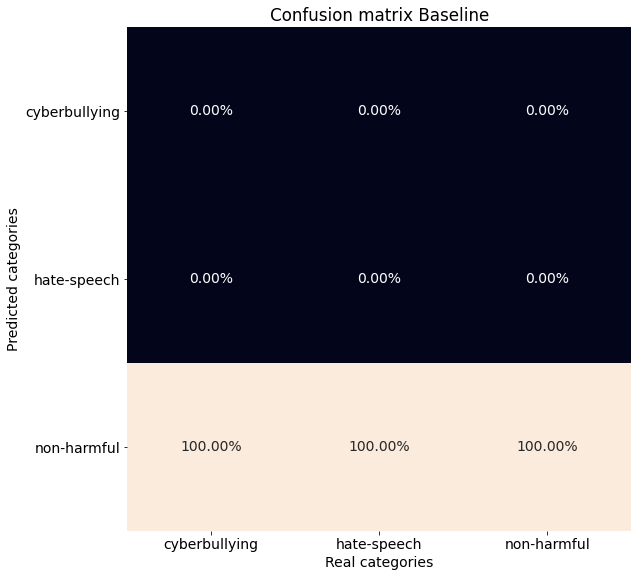

               precision    recall  f1-score   support

cyberbullying       0.00      0.00      0.00        53
  hate-speech       0.00      0.00      0.00       126
  non-harmful       0.92      1.00      0.96      1930

     accuracy                           0.92      2109
    macro avg       0.31      0.33      0.32      2109
 weighted avg       0.84      0.92      0.87      2109

F1 micro-average 0.9151256519677572


In [28]:
tags_val_pred = np.repeat('non-harmful', len(tags_val))
show_classification_report(tags_val, tags_val_pred, title='Confusion matrix Baseline')

Model Baseline jest modelem kompletnie naiwnym, kt√≥ry za ka≈ºdym razem zwraca klasƒô *non-harmful*. S≈Çu≈ºy do stworzenia pewnego "minimum", poni≈ºej kt√≥rego wszelkie dalsze rozwiƒÖzania sƒÖ po prostu nieakceptowalne.

MiarƒÖ F1 micro-average wynosi 0,9151 bƒôdzie ona warto≈õcia referencyjnƒÖ dla ka≈ºdego nastƒôpnego rozwiƒÖzania.

<a id="naive_bayes"></a>
### Naive Bayes

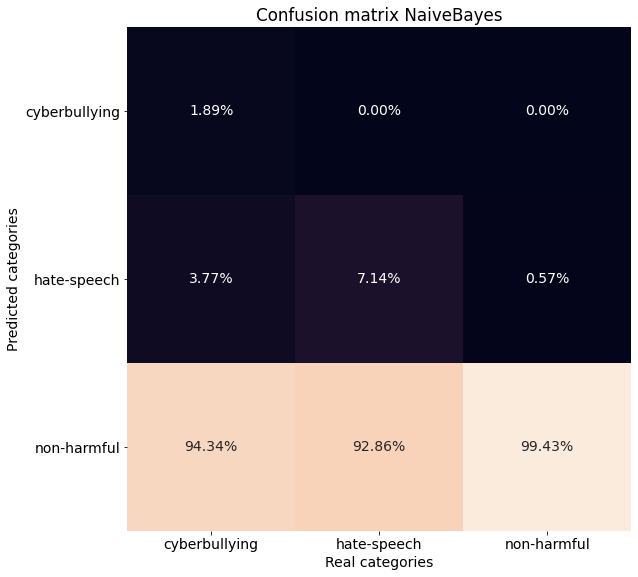

               precision    recall  f1-score   support

cyberbullying       1.00      0.02      0.04        53
  hate-speech       0.41      0.07      0.12       126
  non-harmful       0.92      0.99      0.96      1930

     accuracy                           0.91      2109
    macro avg       0.78      0.36      0.37      2109
 weighted avg       0.89      0.91      0.88      2109

F1 micro-average 0.914651493598862
Inference time: 0.006816 +- 0.005824 seconds


In [29]:
np.random.seed(SEED)
random.seed(SEED)

naive_bayes_params = {
    'alpha': 1.0
}

from sklearn.feature_extraction.text import CountVectorizer

nb_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(**tfidf_params)),
    ('naive_bayes', MultinomialNB(**naive_bayes_params)),
])

nb_pipeline.fit(texts_train_cleaned, tags_train)
tags_val_pred = nb_pipeline.predict(texts_val_cleaned)

show_classification_report(tags_val, tags_val_pred, title='Confusion matrix NaiveBayes')
check_inference_time(texts_train_full, cleaning_pipeline, nb_pipeline)

count_vectorizer = nb_pipeline['count_vectorizer']
classifier = nb_pipeline['naive_bayes']
top_words = show_top_n_words_naive_bayes(classifier, count_vectorizer)

Powy≈ºszy wykres przedstawia udzia≈Ç przewidzianych kategorii (o≈õ Y) w prawdziwych kategoriach (o≈õ X) - warto≈õci w kolumnach sumujƒÖ siƒô do 100%. Warto≈õci na przekƒÖtnych sƒÖ to≈ºsame z warto≈õciƒÖ *recall*.

Warto≈õci *precision* oraz *recall* mo≈ºna interpretowaƒá w nastƒôpujƒÖcy spos√≥b: Dla kategorii *hate-speech* precision (41%) oraz recall (11%) wskazujƒÖ na to, ≈ºe kiedy klasyfikator proponuje kategoriƒô *hate-speech* to trafia on w 41% przypadk√≥w, ale niestety nie jest w stanie zidentyfikowaƒá wszystkich *hate-speech*, przez co pomija oko≈Ço 89% przypadk√≥w. Kr√≥tko mowiƒÖc, jest precyzyjny w typowaniu *hate-speech*, ale nie wy≈Çapie wszystkich.

Miara F1 micro-average jest po≈ÇƒÖczeniem miar *precision* i *recall* - im wiƒôksza warto≈õƒá, tym lepiej - kt√≥ra dodatkowo bierze pod uwagƒô rozk≈Çad tag√≥w w tek≈õcie.

Naive Bayes:

1. Jako≈õci klasyfikacji - Naive Bayes w przeciwie≈Ñstwie do Baseline kategoryzuje do 3, a nie do 1, kategorii, jednak≈ºe jego efektywno≈õƒá pozostawia wiele do ≈ºyczenia, poniewa≈º warto≈õƒá F1 micro-average wskazuje na to, ≈ºe jest gorsza od Baseline o , co jest nie akceptowalne.
2. Mo≈ºliwo≈õƒái interpretacji modelu - BazujƒÖc na rozk≈Çadach prawdopodobie≈Ñstw s≈Ç√≥w, kt√≥rych Naive Bayes siƒô nauczy≈Ç jeste≈õmy w stanie spojrzeƒá kt√≥re s≈Çowa sƒÖ "najwa≈ºniejsze" w ka≈ºdej z trzech kategorii. Pozwala to na zrozumienie kt√≥rymi s≈Çowami najbardziej "kieruje siƒô" w swoim dzia≈Çaniu przy kategoryzacji do danej kategorii. (tabelka ni≈ºej)

In [30]:
pd.DataFrame(top_words)

cyberbullying hate-speech non-harmful
0        jestes      jestes       chyba
1             üëç           ü§£           üòÄ
2          czym   jestescie        wiem
3          masz       kurwa           üòâ
4        polski      pajacu       https
5        prosze       chyba        masz
6         wiesz     kobieto      pewnie
7      bedziesz       debil           üòú
8         chyba      debile       meczu
9          dupe       macie       wisla

3. Poziom skomplikowania - Algorytm Naive Bayesa jest algorytmem prostym - wykorzystuje on czƒôsto≈õci s≈Ç√≥w do skonstruwoania ich rozk≈Çad√≥w prawdopodobie≈Ñstw, kt√≥re nastƒôpnie u≈ºywane sƒÖ do przewidzenia kategorii na postawie s≈Ç√≥w w tek≈õcie.
4. Czasu przetwarzania pojedynczej obserwacji - Ca≈Çy proces przygotowania tekstu do jego predykcji wynosi 0.006816 +- 0.005824 sekund, co uznajƒô za bardzo szybkƒÖ inferencjƒô.

<a id="svm"></a>
### Support Vector Machines

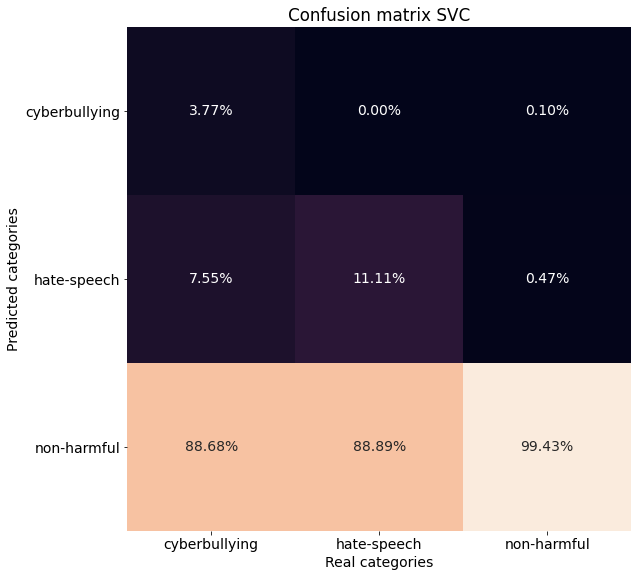

               precision    recall  f1-score   support

cyberbullying       0.50      0.04      0.07        53
  hate-speech       0.52      0.11      0.18       126
  non-harmful       0.92      0.99      0.96      1930

     accuracy                           0.92      2109
    macro avg       0.65      0.38      0.40      2109
 weighted avg       0.89      0.92      0.89      2109

F1 micro-average 0.9174964438122334
Inference time: 0.010239 +- 0.007766 seconds


In [33]:
np.random.seed(SEED)
random.seed(SEED)

svc_params = {
    'C': 1.0,
    'kernel': 'poly',
    'degree': 3
}

svc_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(**tfidf_params)),
    ('svc', SVC(**svc_params)),
])

svc_pipeline.fit(texts_train_cleaned, tags_train)
tags_val_pred = svc_pipeline.predict(texts_val_cleaned)

show_classification_report(tags_val, tags_val_pred, title='Confusion matrix SVC')
check_inference_time(texts_train_full, cleaning_pipeline, svc_pipeline)

Support Vector Classifier:

1. Jako≈õci klasyfikacji - Support Vector Classifier osiƒÖga wynik lepszy ni≈º BaseLine, ale tylko o 0.0023 p. p.
2. Mo≈ºliwo≈õƒái interpretacji modelu - Dla kernela liniowego wsp√≥≈Çczynniki jakich nauczy≈Ç siƒô SVM ≈õwiadczyƒá mogƒÖ o wa≈ºno≈õci danego s≈Çowa ([przyk≈Çadowa praca naukowa wykorzystujƒÖca wsp√≥≈Çczynniki z liniowego SVMa do najsilniejszych wyboru zmiennych](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9598&rep=rep1&type=pdf)), jednak≈ºe w przypadku innych kerneli taka interpretacja jest niemo≈ºliwa.
3. Poziom skomplikowania - SVM jest algorytmem skomplikowanym, kt√≥ry kr√≥tko m√≥wiƒÖc "przenosi" dane do wiƒôkszego wymiaru, w kt√≥rym mo≈ºe istniec liniowa separowalno≈õƒá pomiƒôdzy kategoriami.
4. Czasu przetwarzania pojedynczej obserwacji - Ca≈Çy proces przygotowania tekstu do jego predykcji wynosi 0.010239 +- 0.007766 sekund, co uznajƒô za bardzo szybkƒÖ inferencjƒô.

<a id="polbert"></a>
### PolBERT

In [32]:
np.random.seed(SEED)
random.seed(SEED)

logistic_regression_params = {
    'penalty': 'l2',
    'C': 1.0,
    'random_state': SEED
}

polbert_pipeline = Pipeline([
    ('polbert_feature_constructor', PolBERTFeatureConstructor()),
    ('logistic_regression', LogisticRegression(**logistic_regression_params)),
])

polbert_pipeline.fit(texts_train_cleaned[:100], tags_train[:100])
tags_val_pred = polbert_pipeline.predict(texts_val_cleaned[:100])

check_inference_time(texts_train_full[:100], cleaning_pipeline, polbert_pipeline)

Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/marcin/Marcin/WIEDZA/__zadania_rekrutacyjne/Sotrender/venv/lib/python3.7/site-packages/sklearn/lin

Inference time: 0.600284 +- 0.382061 seconds


Wykorzystanie PolBERTa jest nastƒôpujƒÖce: wyciƒÖgamy z ostatniej ukrytej warstwy jej wagi, kt√≥re stanowiƒÖ zmienne dla regresji logistycznej.

Niestety zadanie nie jest mo≈ºliwe do zrealizowania na moim komputerze (i niestety jest tak ze wszystkimi bilbiotekami do DL), poniewa≈º jest zbyt s≈Çaby aby stosowaƒá na nim bilbioteki do DL.

PolBERT:

1. Jako≈õci klasyfikacji - Niestety nie mo≈ºliwe jest zewalulowanie tego rozwiƒÖzania.
2. Mo≈ºliwo≈õƒái interpretacji modelu - Za≈Ço≈ºenia dzia≈Çania BERTa sƒÖ znane i opisane w pracach naukowych, jednak≈ºe m√≥wiƒÖc o "interpretacji" my≈õlimy o otrzymaniu czego≈õ w postaci prostej struktury/wzoru, kt√≥ry jasno wska≈ºe co jest najwa≈ºniejsze w procesie kategoryzacji. Niestety w przypadku BERTa (czy og√≥lniej sieci neuronowych) jest to jeszcze niemo≈ºliwe.
3. Poziom skomplikowania - PolBERT jest algorytmem bardzo skomplikowanym (obecne SOTA).
4. Czasu przetwarzania pojedynczej obserwacji - Ca≈Çy proces przygotowania tekstu do jego predykcji wynosi 0.600284 +- 0.382061 sekund - inferencja trwa d≈Çugo.

<a id="porownanie_wynikow"></a>
## Por√≥wnanie wynik√≥w

|  | Baseline | Naive Bayes | Support Vector Machine | PolBERT |
|---|---|---|---|---|
| Jako≈õƒá | 0.9151 | 0.9147 | 0.9175 | - |
| Interpretowalno≈õƒá | - | Mo≈ºliwa | Trudna (tylko liniowy) | Niemo≈ºliwa |
| Poziom skomplikowania | - | Niski | ≈öredni | Wysoki |
| Czas przetwarzania (w sekundach) | - | 0.006816 +- 0.005824 | 0.010239 +- 0.007766 | 0.600284 +- 0.382061 |

Naive Bayes zosta≈Ç odrzucony ze wzglƒôdu na nieakceptowalny wynik F1 micro-average, pomimo mo≈ºliwo≈õci jego interpretacji i najkr√≥tszym czasie przetwarzania.

Jako≈õƒá PolBERTa niestety nie by≈Ça mo≈ºliwa do zewaluowania ze wzglƒôdu na ograniczenia sprzƒôtowe. Jednak≈ºe kwestiƒÖ dyskusyjnƒÖ pozostaje fakt, jak dobry musia≈Çby byƒá aby zaakceptowaƒá bardzo wysoki poziom skomplikowania, niemo≈ºliwƒÖ interpretacjƒô oraz d≈Çugi czas inferencji. 

"Naturalnym" wyborem w tym przypadku stajƒô siƒô Support Vector Machines, kt√≥ry jest wywa≈ºonym rozwiƒÖzaniem pomiƒôdzy  jako≈õciƒÖ a poziomem skomplikowania. Jego czas inferencji jest znacznie d≈Çu≈ºszy ni≈º Naive Bayesa (prawie dwukrotnie), ale oscyluje w granicach 0.01 sekund, co uznajƒô za zadowalajƒÖcy wynik.

W ostatnim kroku sprawdzimy jako≈õƒá wybranego rozwiƒÖzania na zbiorze testowym

In [7]:
np.random.seed(SEED)
random.seed(SEED)

texts_train_full_clean = cleaning_pipeline.fit_transform(texts_train_full)
svc_pipeline.fit(texts_train_full_clean, tags_train_full)
tags_test_pred = svc_pipeline.predict(texts_test_cleaned)

tags_meanings = {
    'non-harmful': '0',
    'cyberbullying': '1',
    'hate-speech': '2'
}
tags_test_pred = [f'{tags_meanings[tag]}\n' for tag in tags_test_pred]
with open(os.path.join(path_data_folder, 'test_tags_pred.txt'), 'w') as file:
    file.writelines(tags_test_pred)
    
!perl data/evaluate2.pl data/test_tags_pred.txt

Micro-Average F-score = 86.90%
Macro-Average F-score = 42.61%


Por√≥wnujƒÖc siƒô do innych uczestnik√≥w

| Miejsce | System name | Micro-Average F1 | Macro-Average F1 |
|---|:---:|:---:|:---:|
| 1 | model1-svm | 87.60 | 51.75 |
| 2 | ensamble spacy + tpot + BERT | 87.10 | 46.45 |
| **3** | **Marcin - zadanie rekrutacyjne** | **86.90** | **42.61** | 
| 4 | fasttext | 86.80 | 47.22 |
| 5 | model3-flair | 86.80 | 45.05 |
| 6 | SCWAD-CB | 83.70 | 49.47 |
| 7 | model2-gru | 78.80 | 49.15 |
| 8 | Task 6: Automatic cyberbullying detection (J.K.) | 70.40 | 37.59 |
| 9 | ensamble + fastai | 61.60 | 39.64 |

uzyskujemy wynik 86,90% co plasuje rozwiƒÖzanie na 3 miejscu.

<a id="podsumowanie_budowy_modeli"></a>
## Podsumowanie budowy modeli

Tak jak zosta≈Ço to ju≈º podkre≈õlone we wnioskach po wstƒôpnej analizie danych, najprawdopodobniej nauka klasyfikatorow na tak ma≈Çym zbiorze danych, charakteryzujƒÖcym siƒô niedoreprezentowaniem klas mowy nienawi≈õci (*hate-speech* oraz *cyberbullying*), bƒôdzie trudna. Potwierdzeniem tego faktu sƒÖ wyniki klasyfikator√≥w, kt√≥re pod wzglƒôdem jako≈õci sƒÖ niewiele lepsze ni≈º model naiwny, zwracajƒÖcy za ka≈ºdym razem klase *non-harmful*. Dla podkre≈õlenia trudno≈õci tego zadania, wyliczy≈Çem wynik takiego modelu naiwnego na zbiorze testowym i wynosi on 86.60. PatrzƒÖc na tabelkƒô powy≈ºej z wynikami, 4 z 9 rozwiƒÖza≈Ñ sƒÖ gorsze od modelu naiwnego, a najlepsze rozwiƒÖzanie (model1-svm) jest od niego lepsze o zaledwie 1 p. p., a moje zaledwie o 0.3 p. p.

Ostateczne wybrane rozwiƒÖzanie to model Support Vector Machines, kt√≥ry jest wywa≈ºonym rozwiƒÖzaniem pomiƒôdzy  jako≈õciƒÖ a poziomem skomplikowania. W dodatku szybko przetwarza obserwacje ze ≈õrednim czasem inferencji 0.01 sekund.

<a id="dalsze_kroki"></a>
# Potencjalne dalsze kroki

IstniejƒÖ obszary, w kt√≥rych mo≈ºna by przeprowadziƒá wiƒôcej eksperyment√≥w:

1. Problem niedoreprezentatywno≈õci mo≈ºna by rozwiƒÖzaƒá na dwa sposoby: 
    1. Nadpr√≥bkowanie (ang. *oversampling*) - wygenerowanie dodatkowych sztucznych obserwacji np. korzystajƒÖc z SMOTE. Nigdy nie robi≈Çem tego w temacie NLP, jedynie w modelach klasyfikacyjnych bazujƒÖcych na danych finansowych, jednak≈ºe te rozwiƒÖzanie siƒô tam nie sprawdza≈Ço.
    2. Niedopr√≥bkowanie (ang. *undersampling*) - wybranie podzbioru text√≥w tak aby "zwiƒôkszyƒá" udzia≈Ç klas niedoreprezentowanych. Osobi≈õcie poszed≈Çbym w tym kierunku i zbada≈Ç czy mo≈ºe to poprawiƒá wyniki.
    
2. Najlepszy model, kt√≥ry wygra≈Ç, te≈º by≈Ç SVMem. W prezentacji by≈Ço zawarta informacja, ≈ºe emotikonki zosta≈Çy jednak usuniƒôte ze zbioru, a ja je zawar≈Çem. Warto by≈Çoby sprawdziƒá hipotezƒô czy faktycznie poprawiajƒÖ one klasyfikatory czy te≈º nie. Ja w swojej pracy za≈Ço≈ºy≈Çem, ≈ºe tak, ale warto by≈Çoby to potwierdziƒá.

3. Do klasyfikator√≥w podana zosta≈Ça ca≈Ça macierz TF-IDF. Mo≈ºna by zastanowiƒá siƒô czy nie lepiej wybraƒá z niej pewien podzbi√≥r "najlepszych s≈Çow". W prezentacji rozwiƒÖzania 2. (ensemble spacy + tpot + BERT) zosta≈Ço pokazane, ≈ºe TPOT w trakcie swojego przebiegu zaproponowa≈Ç najlepsze rozwiƒÖzanie, kt√≥re w preprocessingu mia≈Ço wyb√≥r 6% najlepszych zmiennych. W prawdzie nie dotyczy≈Ço to stricte macierzy TF-IDF (a chyba surowych danych? tego brak w prezentacji), ale uwa≈ºam ≈ºe warto by≈Çoby to sprawdziƒá w naszym przypadku.

4. W swoim opracowaniu chcia≈Çem spr√≥bowaƒá u≈ºyƒá PolBERTa, niestety mo≈ºliwo≈õci sprzƒôtowe nie pozwoli≈Çy. Na pewno w kolejnej iteracji przeni√≥s≈Çbym to rozwiƒÖzanie na np. google colab i tam zweryfikowa≈Ç hipotezƒô. Jednak≈ºe z prezentacji rozwiƒÖza≈Ñ jasno wynika, ≈ºe przy tym problemie najlepiej radzƒÖ sobie modele ML, a nie DL - z prostej przyczyny: bardzo ma≈Ça ilo≈õƒá danych.

5. Przy budowie modeli ML zabrak≈Ço optymalizacji hiperparametr√≥w np. z wykorzystaniem optuny. Jednak≈ºe przy tak ma≈Ço licznych zbiorach danych i niedoreprezentatywno≈õci 2 z 3 klas uwa≈ºam, ≈ºe optymalizacja nie jest tutaj rozwiƒÖzaniem problemu a jedynie "doszlifowaniem wynik√≥w". Wiƒôkszy uzysk w tym przypadku uzyskamy albo z poradzeniem sobie z tak ma≈ÇƒÖ ilo≈õciƒÖ danych (patrz punkt 1) lub lepszym przygotowaniem danych i potem utworzonych z nich zmiennych (patrz punkt 2 i 3). 

<a id="kolejny_skrypt"></a>
# Kolejny skrypt

Proszƒô o uruchomienie skryptu `2. train.ipynb`, kt√≥ry omawia zagadnienia CI/CD oraz dzia≈Çanie skryptu `train.py`.